## Exercise 1.4 Hotdog -- no hotdog
This is the first poster hand-in exercise for the course. Please see the associated PDF for instructions.

In [1]:
import os
import numpy as np
import glob
import PIL.Image as Image
from tqdm.notebook import tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.datasets as datasets
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


We always check that we are running on a GPU

In [3]:
if torch.cuda.is_available():
    print("The code will run on GPU.")
else:
    print("The code will run on CPU. Go to Edit->Notebook Settings and choose GPU as the hardware accelerator")
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

The code will run on GPU.


We provide you with a class that can load the *hotdog/not hotdog* dataset you should use from /dtu/datasets1/02516/

In [4]:
class Hotdog_NotHotdog(torch.utils.data.Dataset):
    def __init__(self, train, transform, data_path='/content/drive/MyDrive/hotdog_nothotdog'):
        self.transform = transform
        data_path = os.path.join(data_path, 'train' if train else 'test')

        # Fetching the class labels (hotdog or nothotdog) from directories
        image_classes = [os.path.split(d)[1] for d in glob.glob(data_path + '/*') if os.path.isdir(d)]
        image_classes.sort()
        self.name_to_label = {c: id for id, c in enumerate(image_classes)}

        # Fetching the image paths
        self.image_paths = glob.glob(data_path + '/*/*.jpg')  # <-- Fix: define self.image_paths

        # Load all images and labels into memory
        self.images = []
        self.labels = []
        for image_path in self.image_paths:
          try:
              image = Image.open(image_path)
              c = os.path.split(os.path.split(image_path)[0])[1]
              label = self.name_to_label[c]

              # Apply the transform and store the image and label in memory
              self.images.append(self.transform(image))
              self.labels.append(label)
              print(f"Loaded {image_path}")
          except Exception as e:
              print(f"Error loading {image_path}: {e}")

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        return self.images[idx], self.labels[idx]

Below is the simple way of converting the images to something that can be fed through a network.
Feel free to use something other than $128\times128$ images.

In [5]:
size = 128
train_transform = transforms.Compose([transforms.Resize((size, size)),
                                    transforms.ToTensor()])
test_transform = transforms.Compose([transforms.Resize((size, size)),
                                    transforms.ToTensor()])

batch_size = 64
trainset = Hotdog_NotHotdog(train=True, transform=train_transform)
train_loader = DataLoader(trainset, batch_size=batch_size, shuffle=True)
testset = Hotdog_NotHotdog(train=False, transform=test_transform)
test_loader = DataLoader(testset, batch_size=batch_size, shuffle=False)

Loaded /content/drive/MyDrive/hotdog_nothotdog/train/hotdog/chilidog (275).jpg
Loaded /content/drive/MyDrive/hotdog_nothotdog/train/hotdog/chilidog (379).jpg
Loaded /content/drive/MyDrive/hotdog_nothotdog/train/hotdog/frankfurter (81).jpg
Loaded /content/drive/MyDrive/hotdog_nothotdog/train/hotdog/frankfurter (53).jpg
Loaded /content/drive/MyDrive/hotdog_nothotdog/train/hotdog/frankfurter (17).jpg
Loaded /content/drive/MyDrive/hotdog_nothotdog/train/hotdog/chilidog (294).jpg
Loaded /content/drive/MyDrive/hotdog_nothotdog/train/hotdog/chilidog (360).jpg
Loaded /content/drive/MyDrive/hotdog_nothotdog/train/hotdog/chilidog (297).jpg
Loaded /content/drive/MyDrive/hotdog_nothotdog/train/hotdog/chilidog (348).jpg
Loaded /content/drive/MyDrive/hotdog_nothotdog/train/hotdog/chilidog (359).jpg
Loaded /content/drive/MyDrive/hotdog_nothotdog/train/hotdog/chilidog (383).jpg
Loaded /content/drive/MyDrive/hotdog_nothotdog/train/hotdog/frankfurter (13).jpg
Loaded /content/drive/MyDrive/hotdog_nothotd

Let's look at some images from our data

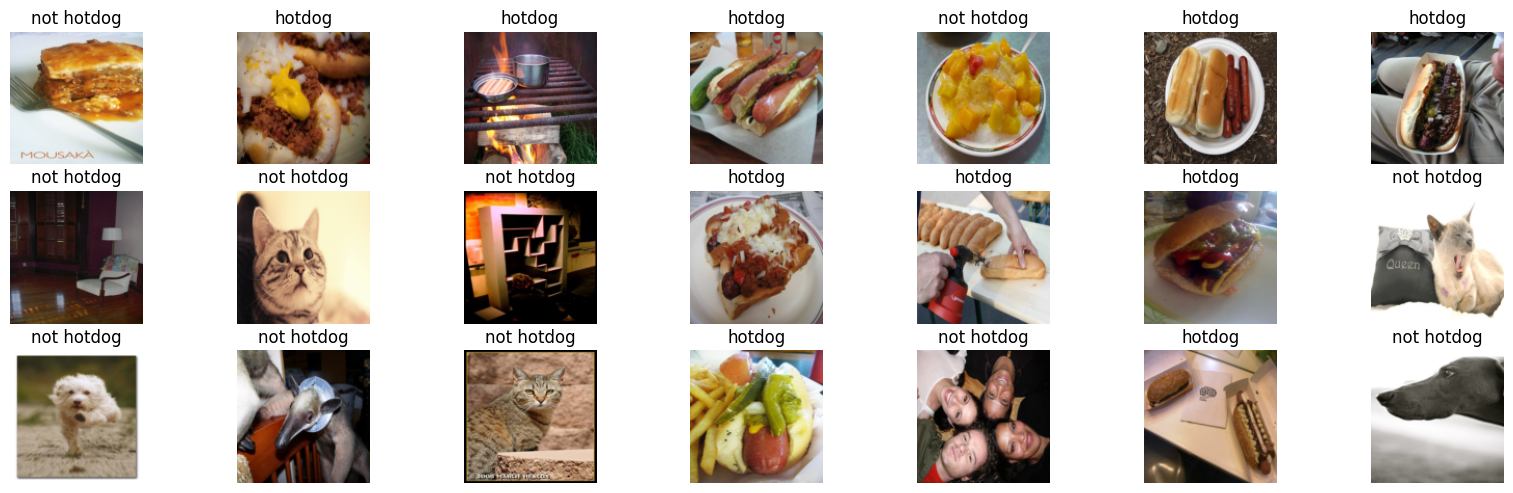

In [7]:
images, labels = next(iter(train_loader))
plt.figure(figsize=(20,10))

for i in range(21):
    plt.subplot(5,7,i+1)
    plt.imshow(np.swapaxes(np.swapaxes(images[i].numpy(), 0, 2), 0, 1))
    plt.title(['hotdog', 'not hotdog'][labels[i].item()])
    plt.axis('off')


Now create a model and train it!


In [59]:
class Network(nn.Module):
    def __init__(self):
        super(Network, self).__init__()
        self.convolutional = nn.Sequential(
                nn.Conv2d(3, 32, kernel_size=3, padding=1),
                nn.ReLU(inplace=True),
                nn.Dropout(0.25),
                nn.Conv2d(32, 32, kernel_size=3, padding=1),
                nn.ReLU(inplace=True),
                nn.MaxPool2d(2,2),
                nn.Dropout(0.25),
                nn.Conv2d(32, 32, kernel_size=3, padding=1),
                nn.ReLU(inplace=True),
                nn.Dropout(0.25)
        )

        self.fully_connected = nn.Sequential(
                nn.Linear(128*128*8, 500),
                nn.ReLU(),
                nn.Dropout(0.7),
                nn.Linear(500, 10),
                nn.Softmax(dim=1))

    def forward(self, x):
        x = self.convolutional(x)
        x = x.view(x.size(0), -1)
        x = self.fully_connected(x)
        return x

In [60]:
model = Network()
model.to(device)
#Initialize the optimizer
# optimizer = torch.optim.SGD(model.parameters(), lr=0.1)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [61]:
#We define the training as a function so we can easily re-use it.
def train(model, optimizer, num_epochs=10):
    def loss_fun(output, target):
        return F.nll_loss(torch.log(output), target)
    out_dict = {'train_acc': [],
              'test_acc': [],
              'train_loss': [],
              'test_loss': []}

    for epoch in tqdm(range(num_epochs), unit='epoch'):
        model.train()
        #For each epoch
        train_correct = 0
        train_loss = []
        for minibatch_no, (data, target) in tqdm(enumerate(train_loader), total=len(train_loader)):
            data, target = data.to(device), target.to(device)
            #Zero the gradients computed for each weight
            optimizer.zero_grad()
            #Forward pass your image through the network
            output = model(data)
            #Compute the loss
            loss = loss_fun(output, target)
            #Backward pass through the network
            loss.backward()
            #Update the weights
            optimizer.step()

            train_loss.append(loss.item())
            #Compute how many were correctly classified
            predicted = output.argmax(1)
            train_correct += (target==predicted).sum().cpu().item()
        #Comput the test accuracy
        test_loss = []
        test_correct = 0
        model.eval()
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            with torch.no_grad():
                output = model(data)
            test_loss.append(loss_fun(output, target).cpu().item())
            predicted = output.argmax(1)
            test_correct += (target==predicted).sum().cpu().item()
        out_dict['train_acc'].append(train_correct/len(trainset))
        out_dict['test_acc'].append(test_correct/len(testset))
        out_dict['train_loss'].append(np.mean(train_loss))
        out_dict['test_loss'].append(np.mean(test_loss))
        print(f"Loss train: {np.mean(train_loss):.3f}\t test: {np.mean(test_loss):.3f}\t",
              f"Accuracy train: {out_dict['train_acc'][-1]*100:.1f}%\t test: {out_dict['test_acc'][-1]*100:.1f}%")
    return out_dict

  0%|          | 0/10 [00:00<?, ?epoch/s]

  0%|          | 0/33 [00:00<?, ?it/s]

Loss train: 1.191	 test: 0.682	 Accuracy train: 50.5%	 test: 58.9%


  0%|          | 0/33 [00:00<?, ?it/s]

Loss train: 0.654	 test: 0.626	 Accuracy train: 61.2%	 test: 66.0%


  0%|          | 0/33 [00:00<?, ?it/s]

Loss train: 0.602	 test: 0.556	 Accuracy train: 70.1%	 test: 70.4%


  0%|          | 0/33 [00:00<?, ?it/s]

Loss train: 0.564	 test: 0.554	 Accuracy train: 72.4%	 test: 71.3%


  0%|          | 0/33 [00:00<?, ?it/s]

Loss train: 0.541	 test: 0.547	 Accuracy train: 74.0%	 test: 72.0%


  0%|          | 0/33 [00:00<?, ?it/s]

Loss train: 0.517	 test: 0.567	 Accuracy train: 75.3%	 test: 72.4%


  0%|          | 0/33 [00:00<?, ?it/s]

Loss train: 0.509	 test: 0.546	 Accuracy train: 75.9%	 test: 72.9%


  0%|          | 0/33 [00:00<?, ?it/s]

Loss train: 0.508	 test: 0.528	 Accuracy train: 77.7%	 test: 73.8%


  0%|          | 0/33 [00:00<?, ?it/s]

Loss train: 0.486	 test: 0.566	 Accuracy train: 77.4%	 test: 74.0%


  0%|          | 0/33 [00:00<?, ?it/s]

Loss train: 0.466	 test: 0.526	 Accuracy train: 80.3%	 test: 73.9%


Text(0, 0.5, 'Accuracy')

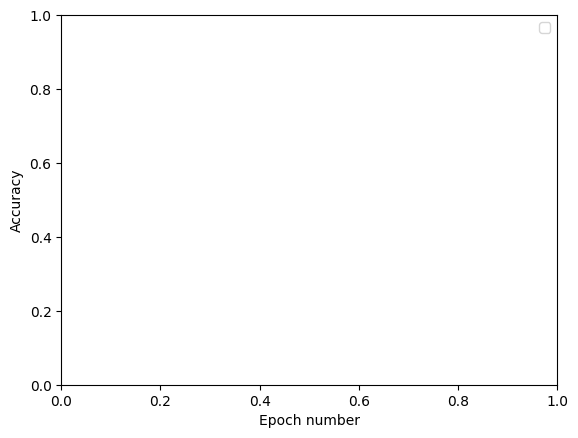

In [62]:
out_dict = train(model, optimizer)
# ...
# ...
plt.legend(('Test error','Train eror'))
plt.xlabel('Epoch number')
plt.ylabel('Accuracy')